# Tanzania Water Wells Classificaton Data Exploration and Cleaning

## Problem Overview

The Tanzania Ministry of Water along with Taarifa, a crowd-source platform, have commisioned the development of a predictive model that is supposed to be able to predict with **water wells** are likely to fail. While much of Tanzanias population has access to basic water services, a large 39% of households still lack this basic need. An estimated 10% of preventable deaths in the country can be attributed to inadequate *wash services*. A predictive model can enable quick **predictive maintenance** on water wells and help ensure water security in many of the rural communities that are disporportionately affected by this problem. 

* ### Project Objectives

1. To conduct exploratory analysis and determine which features to include in our model
2. Determine the cleaning steps to be included in building the model pipeline 

## EDA and Cleaning

In [1]:
# import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from functions import drop_artefacts_and_nulls

warnings.filterwarnings('ignore')
%matplotlib inline 

sns.set_style('darkgrid')

In [2]:
# import and view data
train_set = pd.read_csv('Data/train_set.csv')
train_set_labels = pd.read_csv('Data/train_set_labels.csv')
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

>> ### Examine some columns to determine which ones are irrelevant

From the [data documentation](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#sub_values) features such as `wpt_name` and `id` are artefacts and irrelevant to predictive modelling thus shall be added to a list of features to be dropped by the function *drop_irrelevant_cols*

In [3]:
#examine 'recorded_by'
train_set['recorded_by'].value_counts()

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

>> * `recorded_by` should be dropped as it is irrelevant

Text(0.5, 1.0, 'Payment')

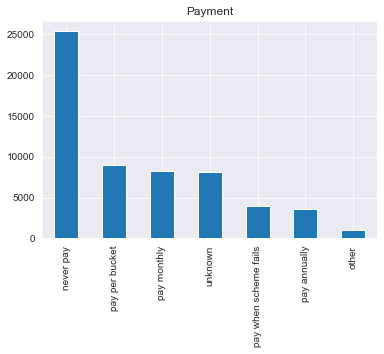

In [4]:
#Examine 'payment'
train_set['payment'].value_counts().plot(kind='bar')
plt.title('Payment')

Text(0.5, 1.0, 'Payment_type')

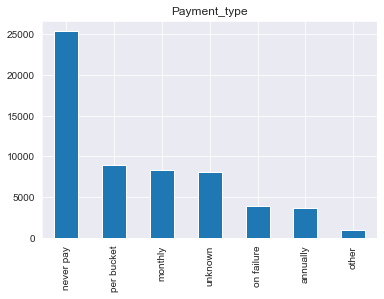

In [5]:
train_set['payment_type'].value_counts().plot(kind='bar')
plt.title('Payment_type')

>> * `payment` and `payment_type` have the same information and are both irrelevant for modelling.

In [6]:
#labels
train_set_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


In [7]:
#examin test set
test_set = pd.read_csv('Data/test_set.csv')
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     14850 non-null  int64  
 1   amount_tsh             14850 non-null  float64
 2   date_recorded          14850 non-null  object 
 3   funder                 13981 non-null  object 
 4   gps_height             14850 non-null  int64  
 5   installer              13973 non-null  object 
 6   longitude              14850 non-null  float64
 7   latitude               14850 non-null  float64
 8   wpt_name               14850 non-null  object 
 9   num_private            14850 non-null  int64  
 10  basin                  14850 non-null  object 
 11  subvillage             14751 non-null  object 
 12  region                 14850 non-null  object 
 13  region_code            14850 non-null  int64  
 14  district_code          14850 non-null  int64  
 15  lg

In [8]:
print('Labels:', train_set_labels['status_group'].unique())

Labels: ['functional' 'non functional' 'functional needs repair']


> * The problem is *ternary*. Need to modify it to approach it as a *binary* classification problem.

In [9]:
#merge predictors and labels for eda
labelled_train_set = pd.merge(train_set, train_set_labels, on='id')
labelled_train_set.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


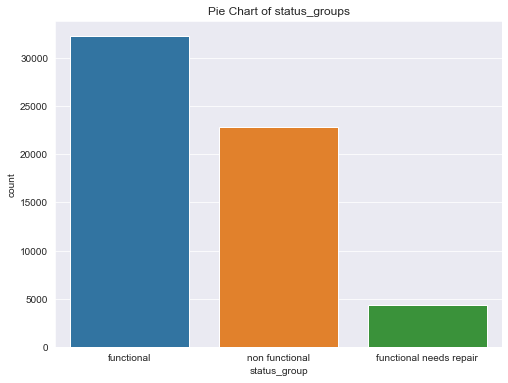

In [10]:
#plot pie chart of status_groups
plt.figure(figsize=(8,6))
sns.countplot(x='status_group', data=labelled_train_set)
plt.title('Pie Chart of status_groups')
plt.show()

> * It would be best to convert `functional needs repair` and `non functional` into a single column to make the problem binary

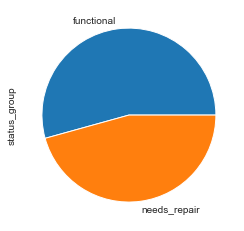

In [11]:
#change subgroup names and convert to binary
labelled_train_set['status_group'] = labelled_train_set['status_group'].replace(['functional needs repair', 'non functional'], 'needs_repair')
labelled_train_set['status_group'].value_counts().plot(kind='pie');

>> * There is an acceptable level of class imbalance 

In [12]:
labelled_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [13]:
#shape
categorical = labelled_train_set.select_dtypes(include='object').columns
numerical = labelled_train_set.select_dtypes(include='number').columns
print('shape:', labelled_train_set.shape)
print('categorical columns:', categorical.values)
print('numerical columns:', numerical.values)

shape: (59400, 41)
categorical columns: ['date_recorded' 'funder' 'installer' 'wpt_name' 'basin' 'subvillage'
 'region' 'lga' 'ward' 'public_meeting' 'recorded_by' 'scheme_management'
 'scheme_name' 'permit' 'extraction_type' 'extraction_type_group'
 'extraction_type_class' 'management' 'management_group' 'payment'
 'payment_type' 'water_quality' 'quality_group' 'quantity'
 'quantity_group' 'source' 'source_type' 'source_class' 'waterpoint_type'
 'waterpoint_type_group' 'status_group']
numerical columns: ['id' 'amount_tsh' 'gps_height' 'longitude' 'latitude' 'num_private'
 'region_code' 'district_code' 'population' 'construction_year']


### Redundant Columns

In [14]:
#print unique values in categorical columns
for col in categorical:
    print(f'{col} values:\n{labelled_train_set[col].unique()}\n')

date_recorded values:
['2011-03-14' '2013-03-06' '2013-02-25' '2013-01-28' '2011-07-13'
 '2011-03-13' '2012-10-01' '2012-10-09' '2012-11-03' '2011-08-03'
 '2011-02-20' '2013-02-18' '2012-10-14' '2013-03-15' '2012-10-20'
 '2011-08-04' '2011-07-04' '2011-09-04' '2011-07-22' '2011-02-22'
 '2011-02-27' '2013-02-10' '2011-10-04' '2013-11-03' '2013-01-21'
 '2013-01-16' '2011-07-11' '2013-03-05' '2013-03-16' '2011-03-23'
 '2011-03-16' '2013-03-19' '2011-03-11' '2011-02-23' '2013-03-28'
 '2011-07-16' '2011-03-27' '2013-02-11' '2013-10-03' '2011-03-12'
 '2011-07-07' '2013-01-15' '2013-03-18' '2012-10-22' '2013-02-05'
 '2011-07-27' '2011-04-04' '2013-02-21' '2011-08-18' '2011-07-31'
 '2011-08-01' '2011-07-14' '2013-02-22' '2013-07-03' '2013-08-03'
 '2013-01-22' '2011-03-22' '2013-05-03' '2013-01-19' '2013-02-09'
 '2011-01-04' '2013-02-04' '2011-03-05' '2011-03-31' '2013-02-27'
 '2011-08-07' '2011-03-30' '2012-10-23' '2011-03-02' '2011-03-04'
 '2013-03-14' '2012-10-18' '2011-08-08' '2011-09-05' '

>> * `source_type` and `source_class` store redudunt information already in `source`. They should be added to the irrelevant columns in **functions.py**
>> * `water_quality` and `quality_group` have redundant information. We can drop the former and keep `quality_group` as it is cleaner
>> * `waterpoint_type_group` and `waterpoint_type` have similar values. We drop the former and keep `waterpoint_type`
>> * `quantity_group` and `quantity` have the same information. We drop the former and keep `quantity`

In [15]:
labelled_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [29]:
#fucntion to plot comparison barcharts
def count_plot_compare(data):
    """
    Plots countplots for subset of columns for comparisons
    Params: data, pandas.DataFrame
    Returns: None
    """
    # #fig and axes
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 10))

    # #loop over subset
    for ind, col in enumerate(data.columns):
        ax = sns.countplot(x=col, data=data, ax=axes[ind])
        ax.set_title(f'{col} values')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # #adjust spacing 
    plt.tight_layout()

    # #show
    plt.show()
    return None

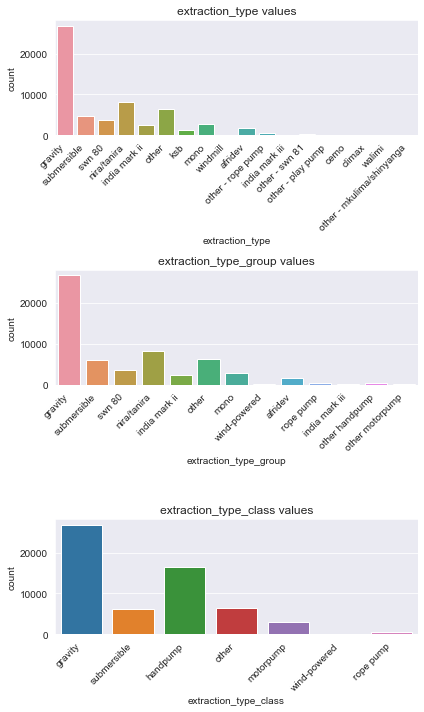

In [30]:
#countplot for 'extrction_type' columns
col_subset_1 = labelled_train_set.iloc[:, 24:27]
count_plot_compare(col_subset_1)

> * Seems that `extraction_type_class` better generalizes this feature. The rest shall be dropped.

In [31]:
labelled_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

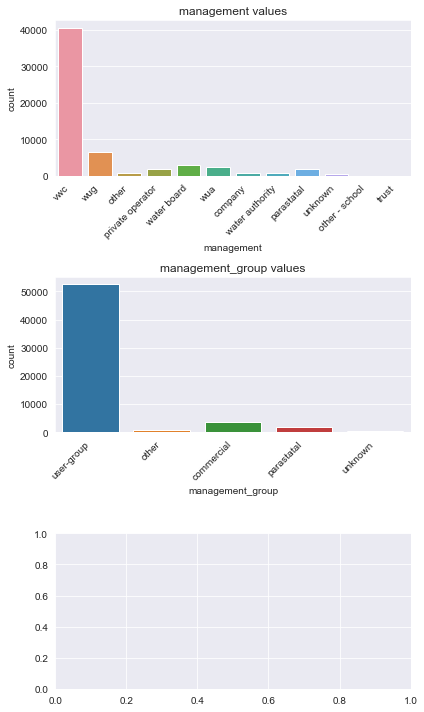

In [34]:
#countplot comparison for 'management' columns
col_subset_2 = labelled_train_set.iloc[:, 27:29]
count_plot_compare(col_subset_2)

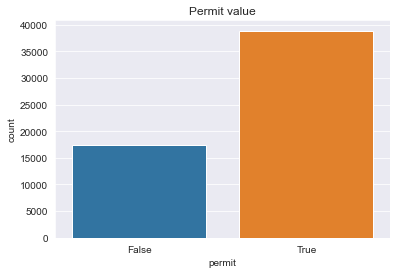

In [17]:
#plot 'permit' values
sns.countplot(x='permit', data=labelled_train_set)
plt.title('Permit value');

> * `permit_value` is a binary value. It might be worth maintaining.

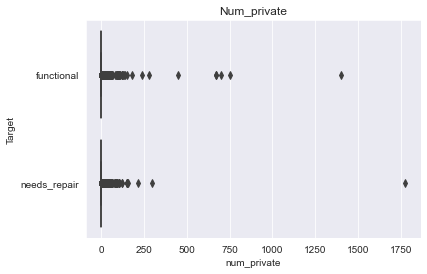

In [18]:
#visualize 'num_private'
vis = sns.boxplot(data=labelled_train_set, x='num_private', y='status_group')
vis.set_title('Num_private')
plt.ylabel('Target');

> * `num_private` seems to be a continuous categorical variable by looking at the distribution. From the [documentation](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#sub_values) it seems to be a miscellaneous column. It shall be dropped.

>> * Check for Validity, Completeness, Consistency and Uniformity

### Missing Values and Irrelevant columns

In [19]:
#Local function to print percentage missing errors
def print_missing_perc(data):
    """
    Print percentage missing values
    Parameters: data
    Returns: None
    """
    cols_with_null = []
    for col in data.columns:
        missing_perc = float(data[col].isna().sum()/len(data[col]))
        if(missing_perc > 0):
            cols_with_null.append((col, missing_perc))
        if(col == data.columns[-1]):
            for null_col in cols_with_null:
                print(f'{null_col[0]} missing: {null_col[1]*100}%')
    if not len(cols_with_null):
        print('No null values')
    return None

In [20]:
print_missing_perc(labelled_train_set)

funder missing: 6.11952861952862%
installer missing: 6.153198653198653%
subvillage missing: 0.6245791245791246%
public_meeting missing: 5.612794612794613%
scheme_management missing: 6.526936026936027%
scheme_name missing: 47.41750841750842%
permit missing: 5.144781144781145%


In [21]:
tww_df = drop_artefacts_and_nulls(labelled_train_set, thresh=.2)
# print_missing_percentage(tww_df)
print_missing_perc(tww_df)

No null values


In [22]:
tww_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48322 entries, 0 to 59399
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             48322 non-null  float64
 1   date_recorded          48322 non-null  object 
 2   gps_height             48322 non-null  int64  
 3   installer              48322 non-null  object 
 4   longitude              48322 non-null  float64
 5   latitude               48322 non-null  float64
 6   basin                  48322 non-null  object 
 7   subvillage             48322 non-null  object 
 8   region_code            48322 non-null  int64  
 9   district_code          48322 non-null  int64  
 10  lga                    48322 non-null  object 
 11  ward                   48322 non-null  object 
 12  population             48322 non-null  int64  
 13  public_meeting         48322 non-null  object 
 14  scheme_management      48322 non-null  object 
 15  pe

In [23]:
#new categorical columns
new_categorical = tww_df.select_dtypes(include='object').columns
new_numerical = tww_df.select_dtypes(include='number').columns
print(f'categorical columns:\n{new_categorical.values}')
print(f'numerical columns:\n{new_numerical.values}')

categorical columns:
['date_recorded' 'installer' 'basin' 'subvillage' 'lga' 'ward'
 'public_meeting' 'scheme_management' 'permit' 'extraction_type_class'
 'management' 'management_group' 'quality_group' 'quantity' 'source'
 'waterpoint_type' 'status_group']
numerical columns:
['amount_tsh' 'gps_height' 'longitude' 'latitude' 'region_code'
 'district_code' 'population' 'construction_year']


In [24]:
#print unique values in categorical columns
for col in new_categorical:
    print(f'{col} values:\n{tww_df[col].unique()}\n')

date_recorded values:
['2011-03-14' '2013-02-25' '2013-01-28' '2011-03-13' '2012-10-01'
 '2012-11-03' '2011-02-20' '2013-02-18' '2012-10-14' '2013-03-15'
 '2012-10-20' '2011-08-04' '2011-07-04' '2011-09-04' '2011-02-22'
 '2011-02-27' '2011-10-04' '2013-11-03' '2013-01-21' '2013-01-16'
 '2013-03-05' '2013-03-16' '2011-03-23' '2011-03-16' '2013-03-19'
 '2011-03-11' '2011-07-16' '2011-03-27' '2013-02-11' '2013-10-03'
 '2011-03-12' '2011-07-07' '2013-03-18' '2012-10-22' '2013-02-05'
 '2011-04-04' '2013-02-21' '2011-08-18' '2011-07-31' '2011-08-01'
 '2013-02-22' '2013-07-03' '2013-08-03' '2011-03-22' '2013-05-03'
 '2013-01-19' '2011-01-04' '2013-02-04' '2011-03-30' '2012-10-23'
 '2011-03-02' '2011-03-04' '2013-03-14' '2011-08-08' '2011-04-11'
 '2013-01-17' '2013-01-20' '2011-07-11' '2013-01-27' '2013-02-19'
 '2012-10-06' '2013-02-13' '2013-02-26' '2013-02-16' '2013-02-17'
 '2011-07-21' '2011-03-07' '2011-07-17' '2011-04-07' '2011-04-10'
 '2013-01-22' '2011-02-25' '2011-07-14' '2011-07-22' '